In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings('ignore')
###########################################################################################

In [2]:
# Load Data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Original shape: {data.shape}")
print(f"Missing values:\n{data.isnull().sum()}")
data.head()
###########################################################################################

Original shape: (7043, 21)
Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Data Cleaning
# Remove customerID
data.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric and handle missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Standardize categorical values
for col in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    data[col] = data[col].replace('No internet service', 'No')
###########################################################################################

In [4]:
# Feature Engineering 
# Create tenure groups
data['TenureGroup'] = pd.cut(data['tenure'], 
                            bins=[0, 12, 24, 48, 72, np.inf],
                            labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr', '6+yr'])

# Create service count feature
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies']
data['NumServices'] = (data[service_cols] == 'Yes').sum(axis=1)

# Create charge ratio feature
data['ChargeRatio'] = data['MonthlyCharges'] / (data['TotalCharges'] + 1e-6)  # Avoid division by zero
###########################################################################################

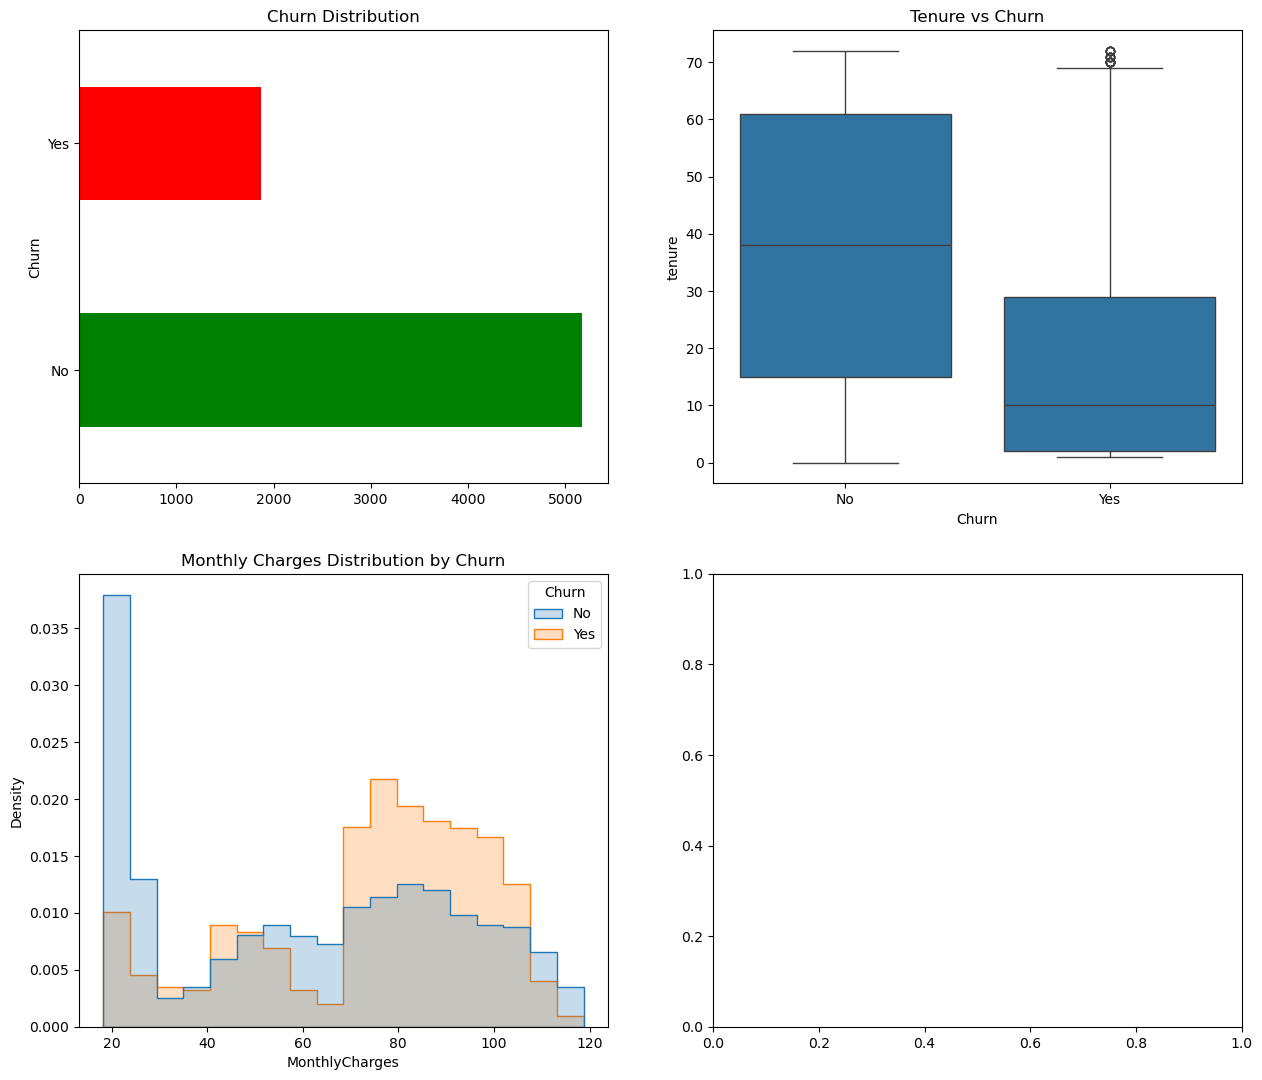

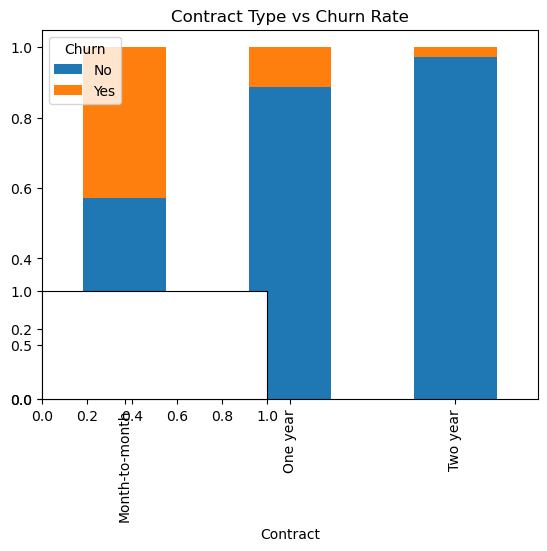

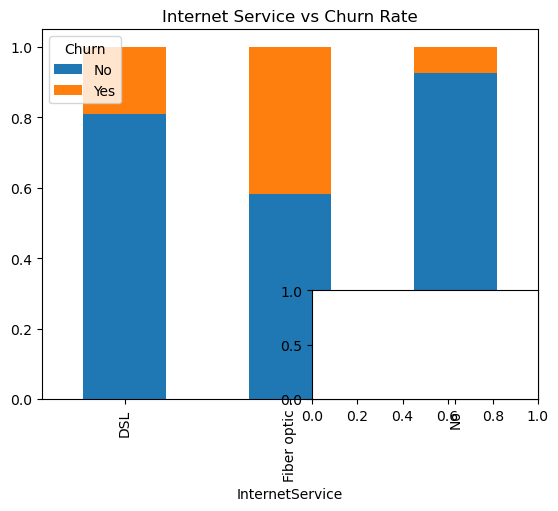

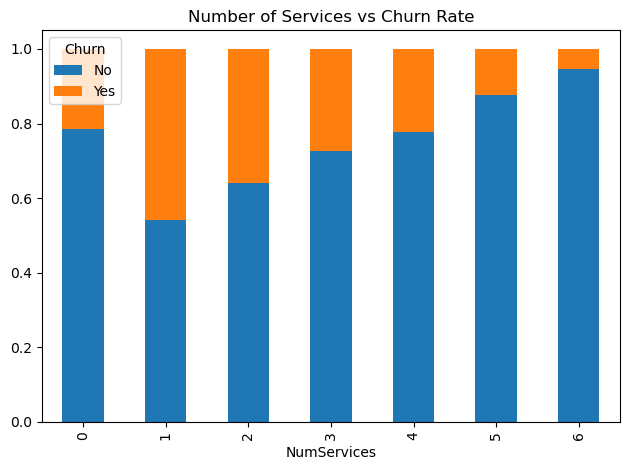

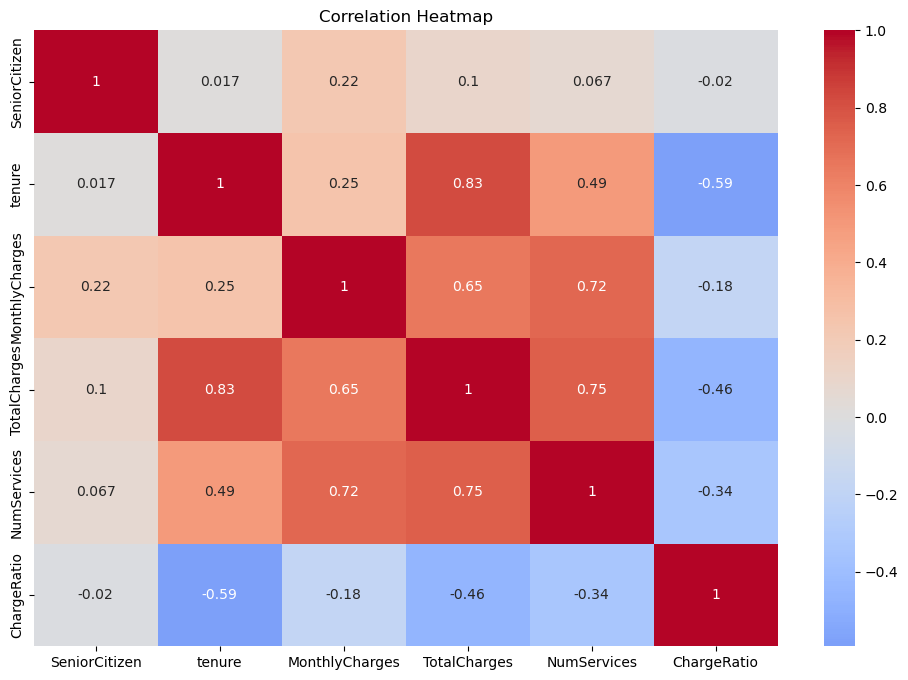

In [6]:
# EDA
plt.figure(figsize=(15, 20))

# Churn distribution
plt.subplot(3, 2, 1)
data['Churn'].value_counts().plot(kind='barh', color=['green','red'])
plt.title('Churn Distribution')

# Tenure vs Churn
plt.subplot(3, 2, 2)
sns.boxplot(x='Churn', y='tenure', data=data)
plt.title('Tenure vs Churn')

# Monthly Charges vs Churn
plt.subplot(3, 2, 3)
sns.histplot(data=data, x='MonthlyCharges', hue='Churn', element='step', stat='density', common_norm=False)
plt.title('Monthly Charges Distribution by Churn')

# Contract type vs Churn
plt.subplot(3, 2, 4)
pd.crosstab(data['Contract'], data['Churn'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Contract Type vs Churn Rate')

# Internet Service vs Churn
plt.subplot(3, 2, 5)
pd.crosstab(data['InternetService'], data['Churn'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Internet Service vs Churn Rate')

# Number of Services vs Churn
plt.subplot(3, 2, 6)
pd.crosstab(data['NumServices'], data['Churn'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Number of Services vs Churn Rate')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=['number']).columns
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()
###########################################################################################

In [8]:
#correlation_matrix = data[numeric_cols].corr()
#print(correlation_matrix)
###########################################################################################

In [9]:
# Preprocessing
# Separate features and target
X = data.drop('Churn', axis=1)
y = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# Remove engineered features from automatic detection
num_cols = [col for col in num_cols if col not in ['NumServices', 'ChargeRatio']]

# Define preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
###########################################################################################

In [10]:
# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
###########################################################################################

In [11]:
# Model Definitions
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42),
    'XGBoost': XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # Handle class imbalance
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
###########################################################################################


Training LogisticRegression
Cross-validated ROC AUC: 0.846 ± 0.012

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
[[747 288]
 [ 81 293]]

Training RandomForest
Cross-validated ROC AUC: 0.821 ± 0.012

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409

Confusion Matrix:
[[926 109]
 [194 180]]


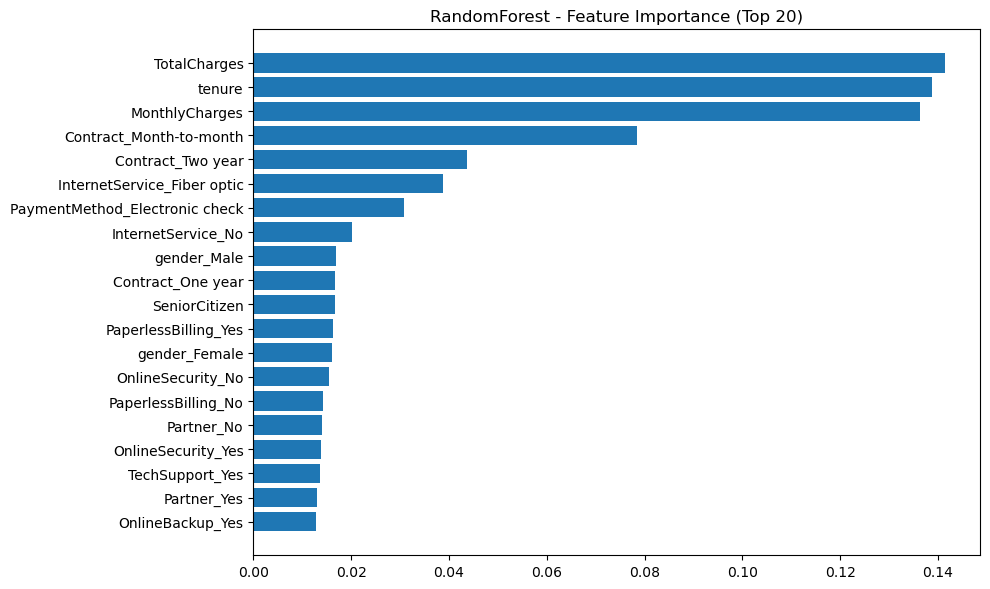


Training XGBoost
Cross-validated ROC AUC: 0.819 ± 0.011

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409

Confusion Matrix:
[[817 218]
 [123 251]]


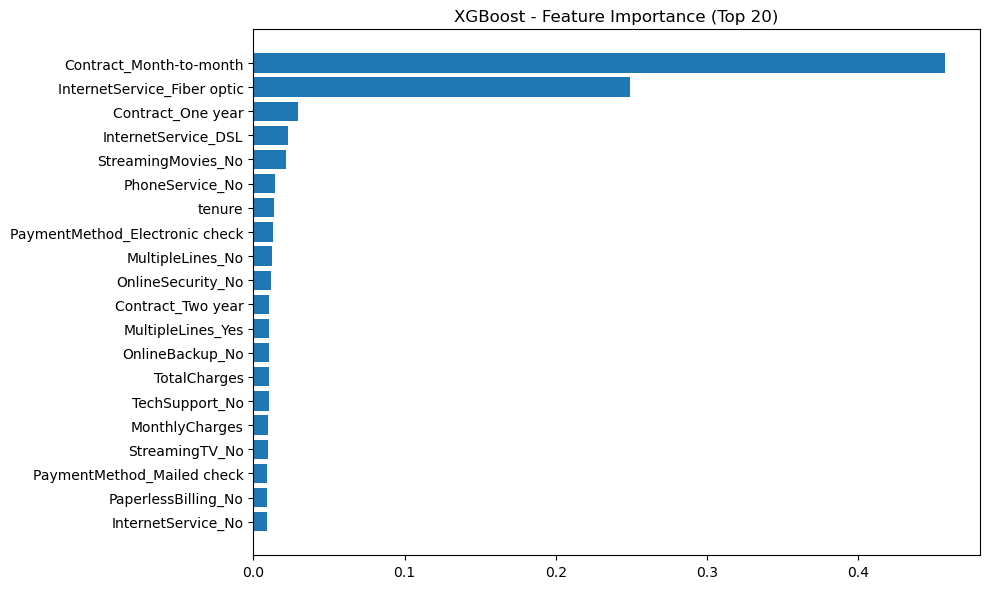


Training GradientBoosting
Cross-validated ROC AUC: 0.848 ± 0.012

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion Matrix:
[[939  96]
 [180 194]]


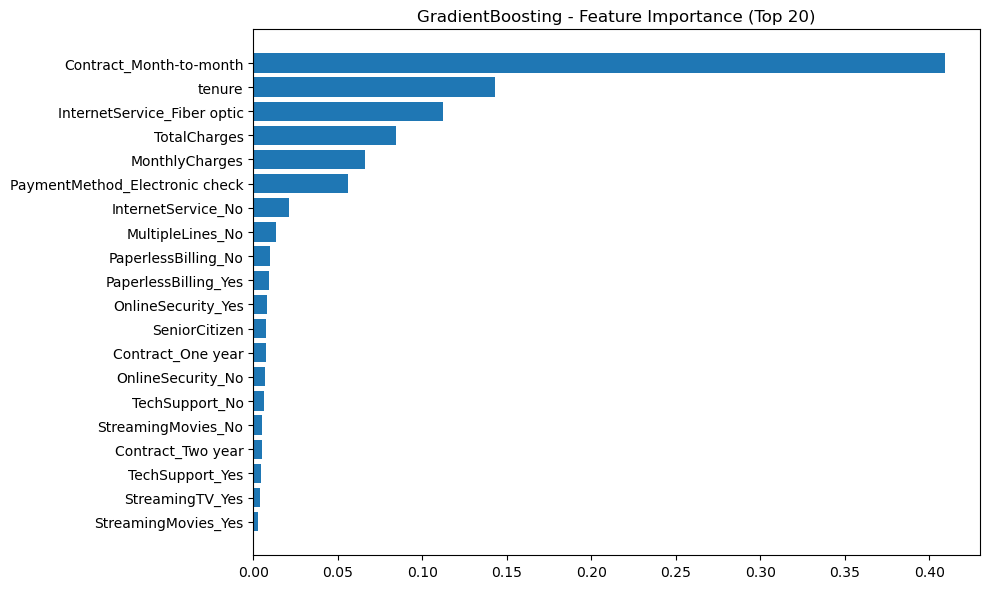


Model Comparison:
                    Accuracy   ROC AUC  Avg Precision
Model                                                
GradientBoosting    0.804116  0.843817       0.658496
LogisticRegression  0.738112  0.841574       0.633562
XGBoost             0.757984  0.822390       0.628796
RandomForest        0.784954  0.822070       0.613868


In [12]:
# Training & Evaluation
results = []
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    print(f"{'='*40}")
    
    # Create pipeline
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"Cross-validated ROC AUC: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    # Full training
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Avg Precision': avg_precision
    })
    
    # Plot feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        # Get feature names after one-hot encoding
        preprocessor.fit(X_train)
        feature_names = (num_cols + 
                         list(preprocessor.named_transformers_['cat']
                             .named_steps['encoder']
                             .get_feature_names_out(cat_cols)))
        
        # For tree-based models in pipeline
        importances = clf.named_steps['model'].feature_importances_
        indices = np.argsort(importances)[::-1][:20]  # Top 20 features
        
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} - Feature Importance (Top 20)")
        plt.barh(range(20), importances[indices][:20][::-1], align='center')
        plt.yticks(range(20), [feature_names[i] for i in indices[:20]][::-1])
        plt.tight_layout()
        plt.show()

# Compare models
results_df = pd.DataFrame(results).set_index('Model').sort_values('ROC AUC', ascending=False)
print("\nModel Comparison:")
print(results_df)
###########################################################################################

In [13]:
# Hyperparameter Tuning
print("\nTuning XGBoost hyperparameters...")

# Create base pipeline
xgb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# Define parameter grid
param_grid = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Grid search with stratified CV
grid_search = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC: {grid_search.best_score_:.3f}")

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nBest Model Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
###########################################################################################


Tuning XGBoost hyperparameters...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best ROC AUC: 0.848

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion Matrix:
[[937  98]
 [179 195]]
ROC AUC: 0.846
